In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y ** 2


In [3]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        concat_size = input_size + hidden_size

        # Weights for the gates (f, i, c_tilde, o)
        self.Wf = np.random.randn(hidden_size, concat_size) * 0.1
        self.Wi = np.random.randn(hidden_size, concat_size) * 0.1
        self.Wc = np.random.randn(hidden_size, concat_size) * 0.1
        self.Wo = np.random.randn(hidden_size, concat_size) * 0.1

        # Biases for the gates
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

    def forward(self, x, h_prev, c_prev):
        concat = np.vstack((h_prev, x))

        # Forget gate
        f = sigmoid(self.Wf @ concat + self.bf)
        # Input gate
        i = sigmoid(self.Wi @ concat + self.bi)
        # Candidate memory cell
        c_tilde = tanh(self.Wc @ concat + self.bc)
        # Current cell state
        c = f * c_prev + i * c_tilde
        # Output gate
        o = sigmoid(self.Wo @ concat + self.bo)
        # Current hidden state
        h = o * tanh(c)

        # Return new hidden state, cell state, and intermediate results for backpropagation
        cache = (x, h_prev, c_prev, f, i, c_tilde, o, c)
        return h, c, cache

    def backward(self, dh, dc, cache):
        x, h_prev, c_prev, f, i, c_tilde, o, c = cache

        # Gradients for the output gate
        do = dh * tanh(c) * dsigmoid(o)

        # Gradients for the cell state
        dc_tanh = dh * o * dtanh(tanh(c)) + dc
        dc_f = dc_tanh * c_prev * f * (1 - f)
        dc_i = dc_tanh * c_tilde * i * (1 - i)
        dc_c = dc_tanh * i * dtanh(c_tilde)

        # Gradients for the gates' weights and biases
        dWf = dc_f @ np.vstack((h_prev, x)).T
        dWi = dc_i @ np.vstack((h_prev, x)).T
        dWc = dc_c @ np.vstack((h_prev, x)).T
        dWo = do @ np.vstack((h_prev, x)).T

        dbf = dc_f
        dbi = dc_i
        dbc = dc_c
        dbo = do

        # Gradients for the hidden and cell states
        dh_prev = self.Wf.T @ dc_f + self.Wi.T @ dc_i + self.Wc.T @ dc_c + self.Wo.T @ do
        dc_prev = f * dc_tanh

        # Return the gradients
        grads = {
            'dWf': dWf, 'dWi': dWi, 'dWc': dWc, 'dWo': dWo,
            'dbf': dbf, 'dbi': dbi, 'dbc': dbc, 'dbo': dbo,
            'dh_prev': dh_prev, 'dc_prev': dc_prev
        }
        
        return grads


In [5]:
# Generate sine wave data
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, num_samples * 2 * np.pi, num_samples)
    y = np.sin(x)
    X = []
    Y = []
    for i in range(len(y) - seq_length):
        X.append(y[i:i + seq_length])
        Y.append(y[i + seq_length])
    return np.array(X), np.array(Y)

seq_length = 20
num_samples = 1000
X, Y = generate_sine_wave(seq_length, num_samples)
X = X.reshape(-1, seq_length, 1)  # Reshape for LSTM


In [7]:
class Linear:
    def __init__(self, input_size):
        self.W = np.random.randn(1, input_size) * 0.1
        self.b = np.zeros((1, 1))

    def forward(self, h):
        return self.W @ h + self.b

def mse_loss(y_pred, y_true):
    return 0.5 * np.sum((y_pred - y_true) ** 2)


In [9]:
# Initialize model
input_size = 1
hidden_size = 64
lstm = LSTM(input_size, hidden_size)
linear = Linear(hidden_size)

# Hyperparameters
learning_rate = 0.001
epochs = 1000

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(X)):
        x_seq = X[i].reshape(-1, 1)
        target = Y[i]
        
        # Initialize hidden and cell states
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        for t in range(len(x_seq)):
            x_t = x_seq[t].reshape(1, 1)
            h, c, cache = lstm.forward(x_t, h, c)

        # Final prediction
        y_pred = linear.forward(h)
        
        # Compute loss
        loss = mse_loss(y_pred, target)
        total_loss += loss

        # Backward pass
        dh = y_pred - target
        dc = 0  # Cell state gradient (not used here)

        # Perform backpropagation through time (BPTT)
        grads = lstm.backward(dh, dc, cache)
        
        # Update weights
        lstm.Wf -= learning_rate * grads['dWf']
        lstm.Wi -= learning_rate * grads['dWi']
        lstm.Wc -= learning_rate * grads['dWc']
        lstm.Wo -= learning_rate * grads['dWo']
        
        lstm.bf -= learning_rate * grads['dbf']
        lstm.bi -= learning_rate * grads['dbi']
        lstm.bc -= learning_rate * grads['dbc']
        lstm.bo -= learning_rate * grads['dbo']

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {total_loss / len(X)}')


Epoch 0/1000 - Loss: 0.2583136108194977
Epoch 100/1000 - Loss: 0.015086867409148077
Epoch 200/1000 - Loss: 0.005271084204121657
Epoch 300/1000 - Loss: 0.0038363434831473354
Epoch 400/1000 - Loss: 0.005114182756601879
Epoch 500/1000 - Loss: 0.004310429869885744
Epoch 600/1000 - Loss: 0.002130913656194363
Epoch 700/1000 - Loss: 0.0017243873835068027
Epoch 800/1000 - Loss: 0.002330927271487239
Epoch 900/1000 - Loss: 0.0012677768960868362


Text(0, 0.5, 'Value')

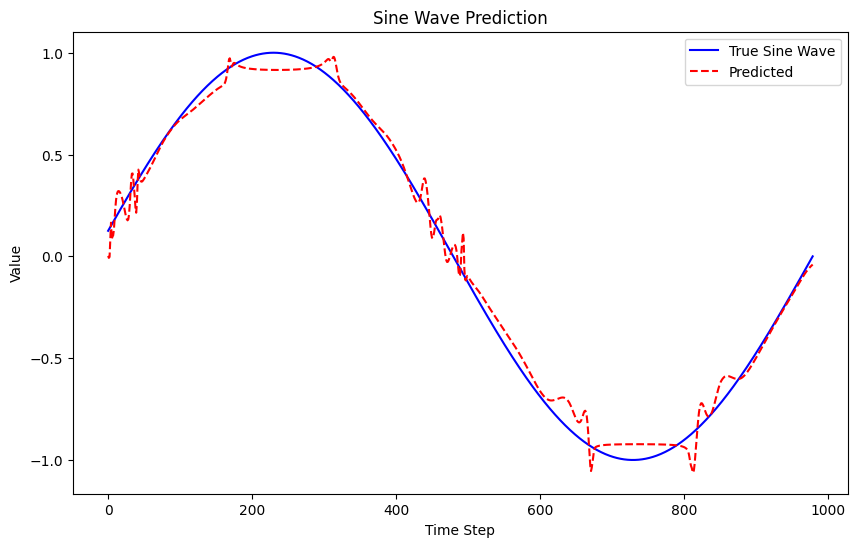

In [10]:
# Plot predictions
predictions = []
for i in range(len(X)):
    x_seq = X[i].reshape(-1, 1)
    h = np.zeros((hidden_size, 1))
    c = np.zeros((hidden_size, 1))
    for t in range(len(x_seq)):
        x_t = x_seq[t].reshape(1, 1)
        h, c, cache = lstm.forward(x_t, h, c)
    y_pred = linear.forward(h)
    predictions.append(y_pred.item())

# Plotting the sine wave and predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(Y)), Y, label="True Sine Wave", color="blue")
plt.plot(np.arange(len(predictions)), predictions, label="Predicted", color="red", linestyle="--")
plt.legend()
plt.title('Sine Wave Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
